# 【問題1】K-meansクラスの作成
###### 非階層クラスタリングの手法であるK-meansのクラスを作成してください。名前はScratchKMeansとしてください。
###### 教師なし学習であるクラスタリングになるため、ここまでの回帰や分類とは異なるパイプラインを作成することになります。
###### メソッドやパラメータなどはscikit-learnを参考にしてください。
###### sklearn.cluster.KMeans — scikit-learn 0.20.0 documentation
###### 検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。


DBSCANの方が実務上よく使う

クラスタリングのための人工データセット
クラスタリングを実験するための人工データセットを作成するコードを用意しました。スクラッチの過程で利用してください。
このmake_blobs関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 _（アンダースコア） で受け取っています。
シンプルデータセット3

目的関数
K-meansは以下のクラスタ内誤差平方和（SSE, Sum of Squared Errors）を最小化する 
rnkとμkを求めることで学習を行います。この数式自体は学習時にはコーディングする必要がありませんが、クラスタ数 K
 を決めるためのエルボー法で使います。エルボー法の実装は問題2で扱います。
$
SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2
$

In [12]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import random

class ScratchKMeans():
    """""
    パラメータ
    --------------------------------
    
    """""
    
    def __init__(self,n_clusters=4,n_init=10,max_iter=100,tolerance = 0.0001,verbose=False):
        self.n_init = n_init #　初期値の設定回数
        self.max_iter = max_iter #初期値の最大更新回数
        self.verbose = verbose #学習過程を出力するかどうかの判断
        self.n_clusters = n_clusters #分類するクラスター数
        self.tolerance = tolerance #許容できる中心点と重心の差
        self.best_SSE = 0
        self.best_center_points = None
        self.best_cluster_number = None       
        #X_val、y_valの存在を宣言しておく
        self.X_val = None

        
    def fit(self, X, X_val=None):
        
        """
        線形回帰を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
    
        
        
        """
        検証データを格納
        """        
        self.X_val = X_val
        
        
        """
        #各試行の結果を順々に格納していくリストを作成
        """
        #SSEのリストを作成
        SSE_list = []
        #中心点のリストを作成
        center_points_list = []
        #各店のクラスタ番号を作成
        cluster_number_list = []
        #試行回数を決定
        self.n_init = 30
        
        #初期値設定後の学習を開始
        for init in range(0,self.n_init):

            #中心点をランダムに設定
            center_points = np.array(random.sample(list(X), self.n_clusters)) # データを一旦リストに直してからrandom.sample(X, 重複無しサンプルの選択数)を使い、またnumpy配列に直す


            #初期値更新を開始
            for iter in range(0,self.max_iter): #指定した試行回数だけ初期値設定を繰り返す

                #各点と最も近い距離の中心点を求める 
                cluster_number= [] #各インデックスの点がどの中心点に割り当てられるかを示したリストを作成

                #中心点k個と全Xのn個の距離を算出し、割り当てられる中心点を作成していく。
                for m in range(0,len(X)): #全てのX点で繰り返す
                    min_distance = float('inf') # 無限大を設定
                    temp_cluster = None
                    for i,point in enumerate(center_points):
                        if ((center_points[i] - X[m]) @ (center_points[i] - X[m]).T) ** 0.5 < min_distance: #距離が最小値を更新している場合の条件分岐
                            min_distance = ((center_points[i] - X[m]) @ (center_points[i] - X[m]).T) ** 0.5 #最も近い点との距離を更新
                            temp_cluster = i #最も近い点の番号

                    cluster_number.append(temp_cluster) #最も近い点を番号をリストに記録していく
                
                
                #割り当てられたサンプルのない中心点は、最も遠くにある点に移動させる。
                clusters_Counter = collections.Counter(cluster_number)
                for cluster, counts in clusters_Counter.items():
                    if counts == 0:
                        max_distance = 0
                        for m in range(0,len(X)): #全てのX点で繰り返す
                             if ((center_points[int(cluster)] - X[m]) @ (center_points[int(cluster)] - X[m]).T) ** 0.5 > max_distance: #距離が最大値を更新している場合の条件分岐
                                center_points[int(cluster)] = X[m]
                                

                # 更新前後の距離を格納していくリスト
                distance_list = []

                #新しい中心点を一時的に格納しておく配列
                new_center_points = np.array(random.sample(list(X), self.n_clusters))



                #中心点の更新
                for k in range(0,self.n_clusters): #中心点の数だけ繰り返す
                    index_k = np.where(np.array(cluster_number)==k) #一番近い中心点がjとなっている点のインデックスを返す
                    #print("試行回数と中心点番号:",iter,k,index_k)
                    new_center_points[k] = X[index_k].mean(axis=0) #新しい中心点を算出する。
                    

                # 次に設定する中心点と現在の中心点の距離をクラスターの数だけ算出し、リストに格納
                for k in range(0,self.n_clusters):
                    distance_list.append( \
                    ((new_center_points - center_points)[k] @ (new_center_points - center_points)[k].T) ** 0.5)


                #更新前と更新後のクラスター距離の最大値より許容値が小さい場合、繰り返しを終了
                if max(distance_list) <= self.tolerance :
                    center_points = new_center_points
                    break

                else:
                    center_points = new_center_points



            #終了用の作業調整
            #最終的に設定された中心点の座標を設定し、かつXごとに最短距離にある番号を振る
            last_center_points = center_points
            last_cluster_number = cluster_number
            SSE = 0
            for m in range(len(X)):
                SSE += ((last_center_points[cluster_number[m]] - X[m]) ** 2).sum() ** 0.5
            SSE_list.append(SSE) #SSEの値を記録
            center_points_list.append(last_center_points) #中心点の座標を記録
            cluster_number_list.append(last_cluster_number) #属するクラスターの番号を記録

        best_score_index = np.argmin(SSE_list)
        self.best_SSE = SSE_list[best_score_index]
        self.best_center_points = center_points_list[best_score_index]
        self.best_cluster_number = cluster_number_list[best_score_index]


    def predict(self,X):
        pred_cluster_number_list = []
        
        #中心点k個と全Xのn個の距離を算出し、割り当てられるクラスタの番号を返してゆく。
        for m in range(0,len(X)): #全てのX点で繰り返す
            min_distance = float('inf') # 無限大を設定
            pred_temp_cluster = None
            for i,point in enumerate(self.best_center_points):
                if ((self.best_center_points[i] - X[m]) @ (self.best_center_points[i] - X[m]).T) ** 0.5 < min_distance: #距離が最小値を更新している場合の条件分岐
                    min_distance = ((self.best_center_points[i] - X[m]) @ (self.best_center_points[i] - X[m]).T) ** 0.5 #最も近い点との距離を更新
                    temp_cluster = i #最も近い点の番号

            pred_cluster_number_list.append(temp_cluster) #最も近い点を番号をリストに記録していく                
                    
        return np.array(pred_cluster_number_list)
    
    
    def objective_function_score(self):
        
        return self.best_SSE
        

    def loss_graph(self):
        #損失関数の遷移
        plt.figure(figsize=(3, 2), dpi=200)
        plt.title('model loss')
        plt.xlabel('iter')
        plt.ylabel('Closs entropy')
        if (self.X_val is not None) and (self.y_val is not None): #　検証データがある場合
            plt.plot(self.val_loss, color='red',label = "val_loss",linewidth=1,linestyle='solid')
        plt.plot(self.loss, color='blue',label = "train_loss",linewidth=1,linestyle='dashed')
        plt.legend()


In [13]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

#選択した点と全ての点の距離を求める
((u_1[0] - X[0]) @ (u_1[0] - X[0]).T) ** 0.5 # 例えば最初の点同士を比較した場合
((u_1[1] - X[0]) @ (u_1[1] - X[0]).T) ** 0.5 # 例えば最初の点同士を比較した場合
((u_1[2] - X[0]) @ (u_1[2] - X[0]).T) ** 0.5 # 例えば最初の点同士を比較した場合
((u_1[3] - X[0]) @ (u_1[3] - X[0]).T) ** 0.5

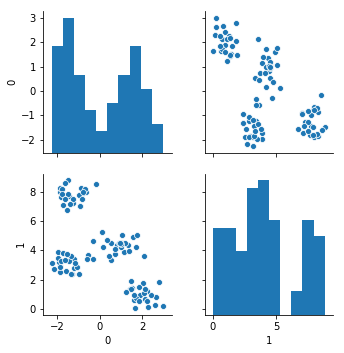

In [14]:
import seaborn as sns
import pandas as pd
# JupyterLab で実行する際は、この行を書くことで描画できるようになります。
%matplotlib inline

sns.pairplot(pd.DataFrame(X))

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


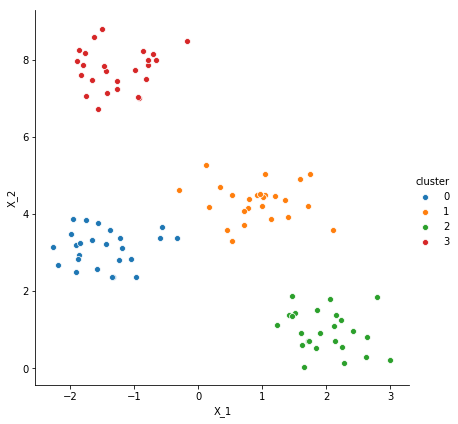

In [15]:
#色付けしたプロットとクラスタを作成
k_means = ScratchKMeans()
k_means.fit(X)
plot_data = pd.concat([pd.DataFrame(k_means.best_cluster_number,columns=["cluster"]),pd.DataFrame(X,columns=["X_1","X_2"])],axis=1)
sns.pairplot(plot_data , hue='cluster',size=6,x_vars=['X_1'], y_vars=['X_2'])

# 【問題2】エルボー法の実装
###### K-meansにおいて中心点の個数 k は人為的に決める必要があるが、その判断方法としてエルボー法があります。
###### SSEを縦軸、クラスタ数 k を横軸にした折れ線グラフを表示します。
###### このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: Mean of empty slice.


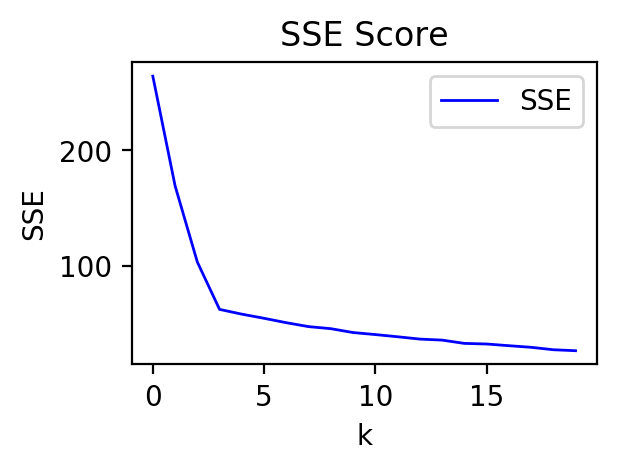

In [16]:
#kの値変更によるスコア変化を追う

max_k = 20
SSE_transition_list = []


for k in range(1,max_k+1):
    k_means_model = ScratchKMeans(n_clusters=k)
    k_means_model.fit(X)
    SSE_transition_list.append(k_means_model.objective_function_score())

plt.figure(figsize=(3, 2), dpi=200)
plt.title('SSE Score')
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(SSE_transition_list, color='blue',label = "SSE",linewidth=1,linestyle='solid')
plt.legend()

# 【問題3】（アドバンス課題）シルエット図
###### コーディング
###### kを決める助けになるものとしてシルエット図もあります。
Matplotlibを使い可視化するコードは用意しました。以下を与えてください。  
silhouette_vals : shape(n_samples,)のndarray、各データ点のシルエット係数  
silhouette_avg : float、シルエット係数の平均値  
y_km : shape(n_samples,)のndarray、各データ点のクラスタラベル名  
###### cluster_labels : list、クラスタのラベル名のリスト
###### n_clusters : int、クラスタ数
###### n番目のデータ点に対するシルエット係数 sn は以下の数式でを求められます。この数式を実装し、シルエット図を確認してください。

$
 s_n = \frac{b_n-a_n}{max(b_n,a_n)}
$
    
###### an: 凝集度。同じクラスタ内の他のデータ点との距離の平均値。
###### bn: 乖離度。最も近い他のクラスタ内の全てのデータ点との距離の平均値。
###### 乖離度 bが大きく、凝集度 a が小さい時が理想的であり、シルエット係数 s は1に近くなります。

※今回は実装せず

In [18]:
from matplotlib import cm

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate([0,1,2,3]):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

NameError: name 'silhouette_vals' is not defined

# ■卸売業者のデータ分析

Data Folderの中からWholesale customers data.csvをダウンロードしてください。これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。顧客は小売店やレストランです。RegionとChannelは取り覗き、金額のデータでK-meansを利用します。

In [19]:
data_original = pd.read_csv('Wholesale customers data.csv')
data_original.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


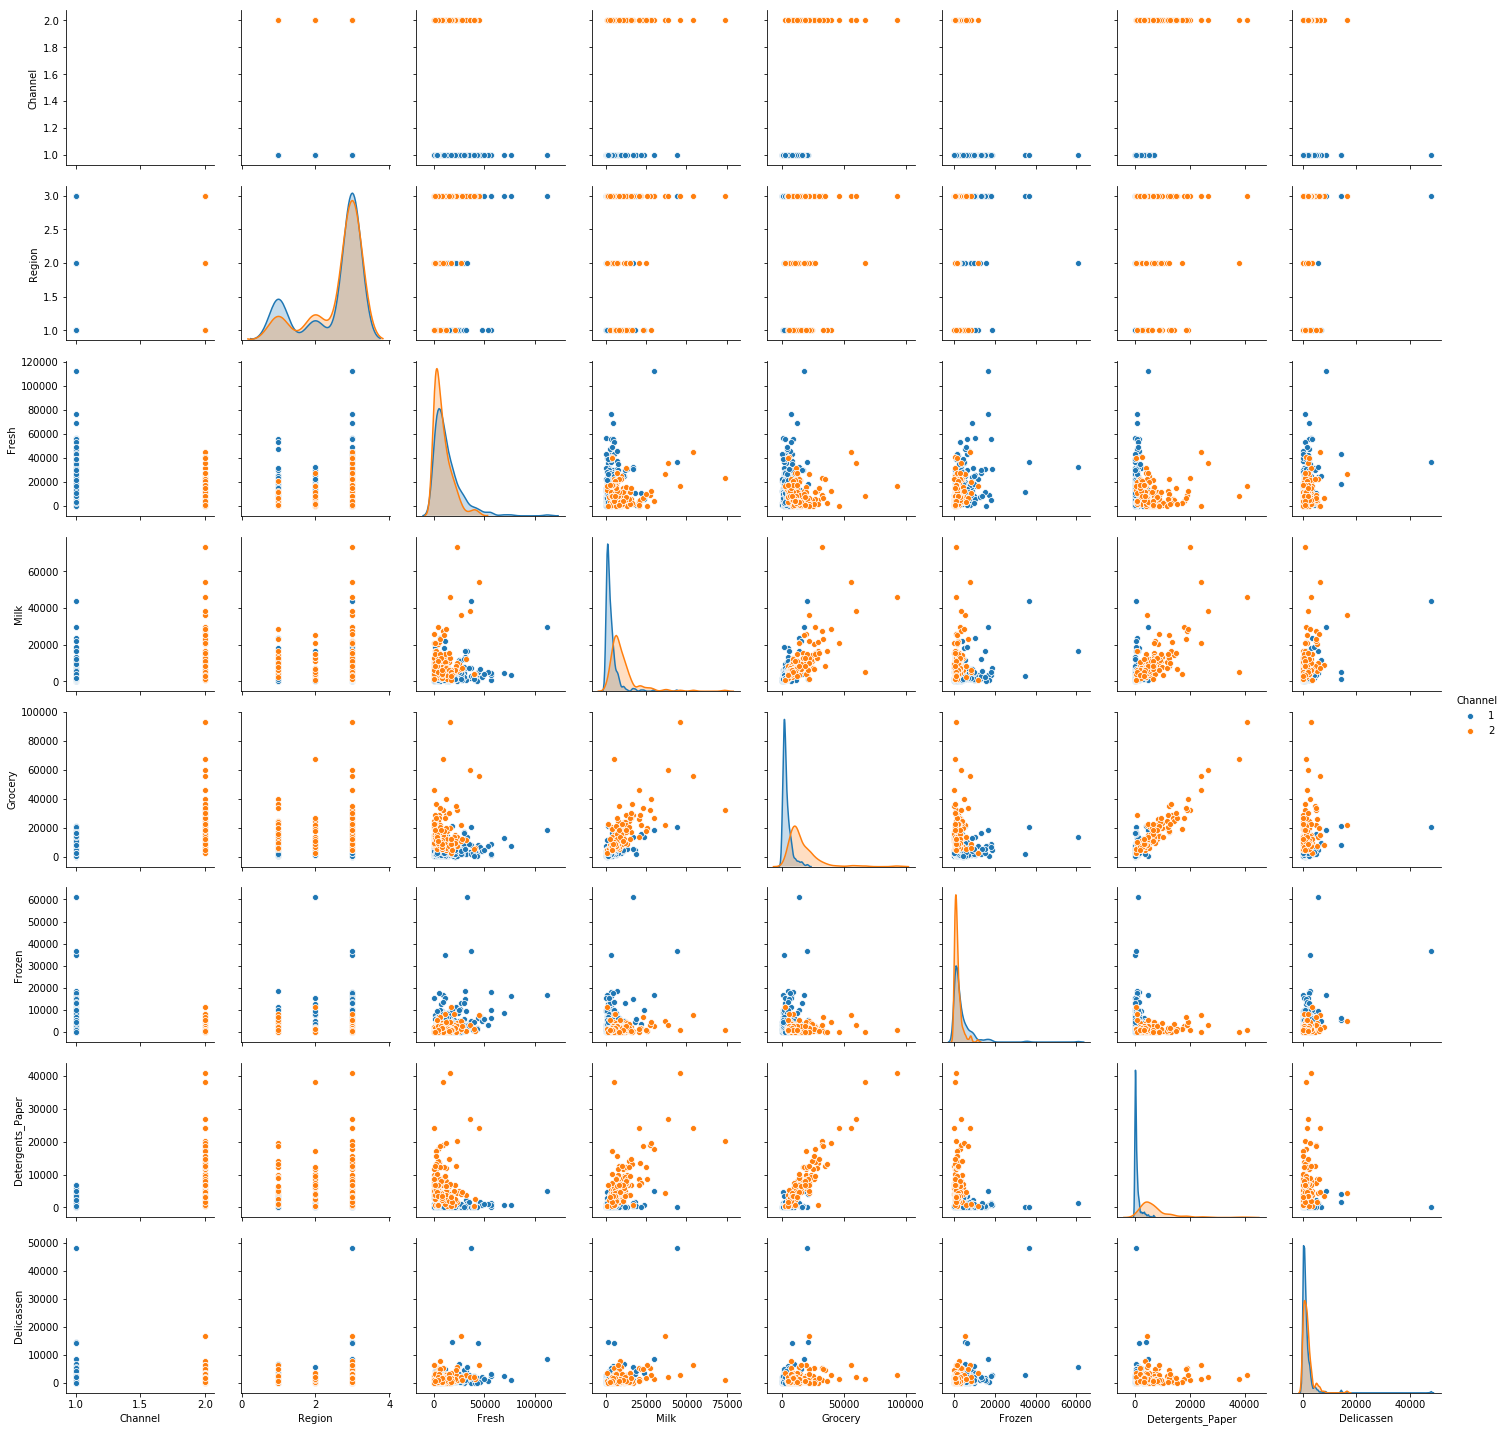

In [20]:
sns.pairplot(data_original, hue="Channel")

In [21]:
data = data_original.drop(["Channel","Region"],axis=1)
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


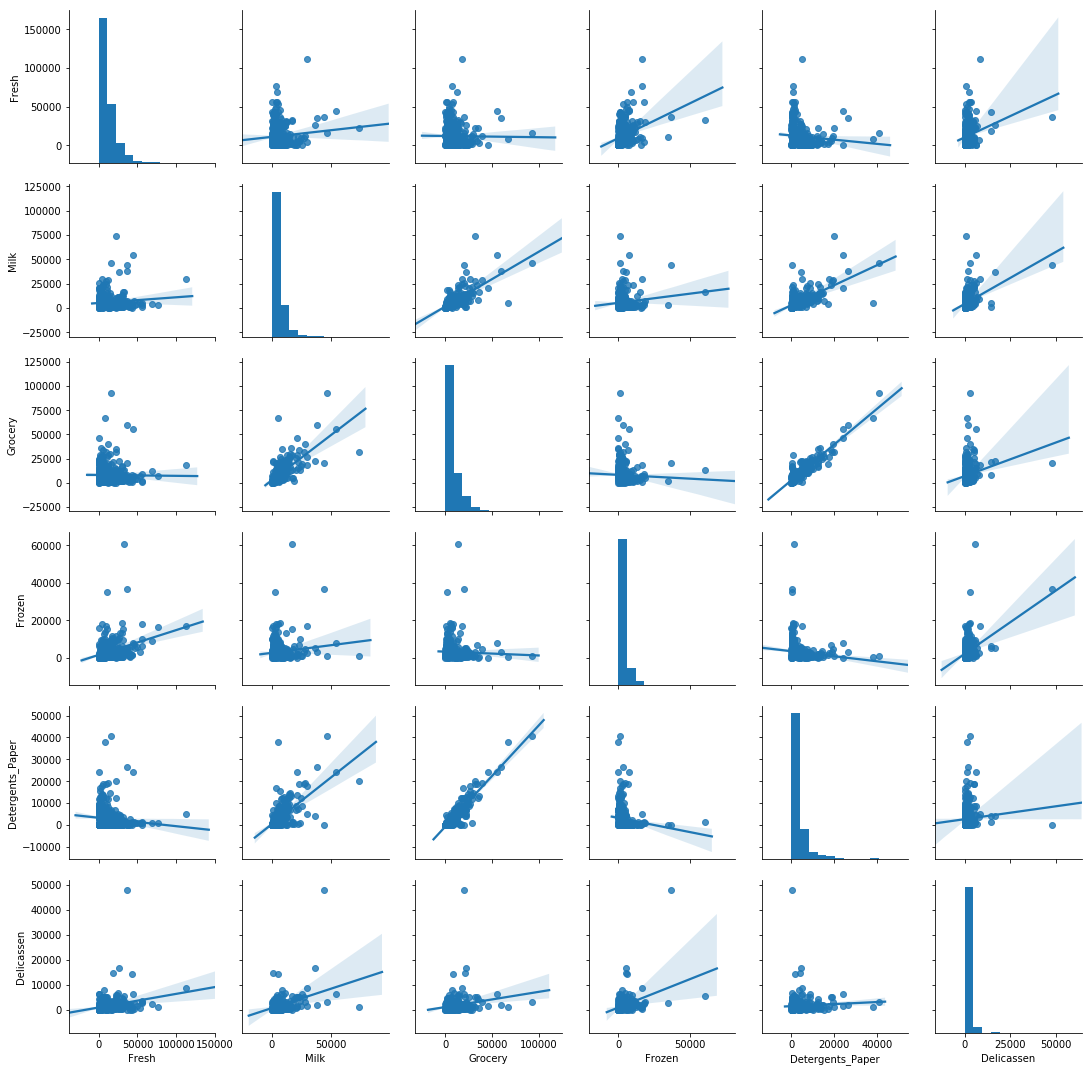

In [22]:
sns.pairplot(data,kind='reg')

#### 対数変換

In [23]:
data_log = np.log(data_original.iloc[:,2:])
data_log.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


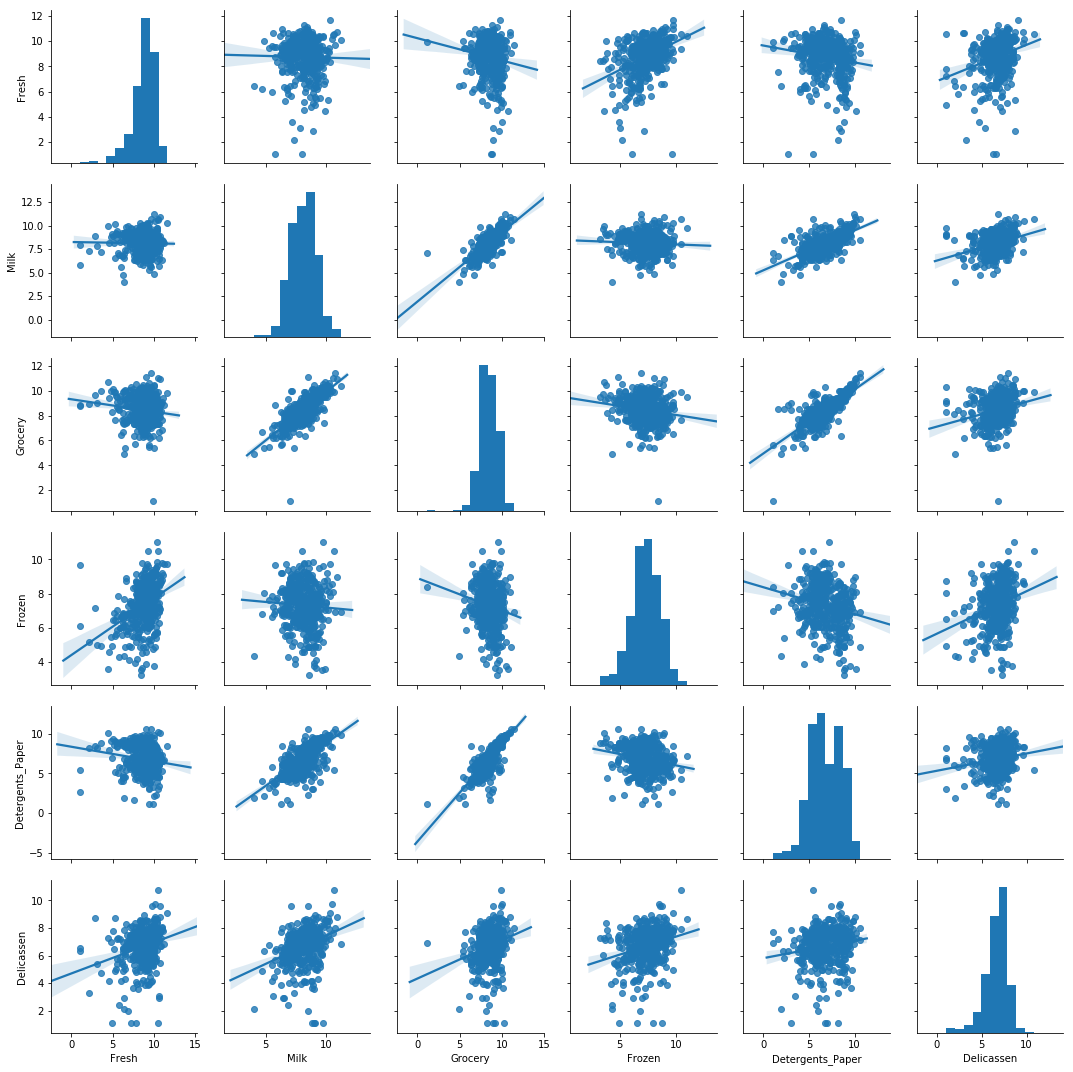

In [29]:
sns.pairplot(data_log,kind='reg')

#### 次元削減  
金額に関する特徴量は6個ありますが、可視化するために次元削減を行います。これに関してはscikit-learnによるPCAのサンプルコードを用意したので利用してください。

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components = 2)
pca = pca.fit(data_log)
data_pca = pca.transform(data_log)

分散説明率：何次元に削減したら、元のデータを何％説明できていることになるかを示した指標である。

[0.44237417 0.71894523 0.83511865 0.93129585 0.97705265 1.        ]


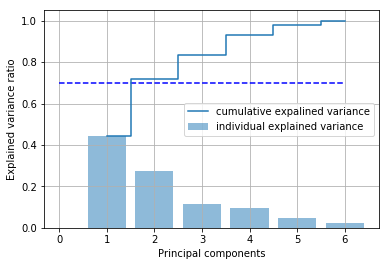

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(data_log)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

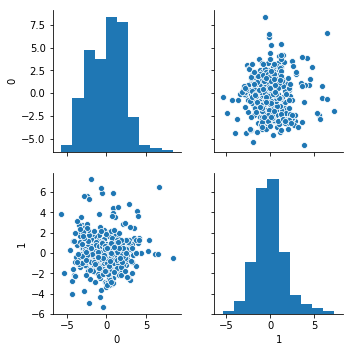

In [26]:
sns.pairplot(pd.DataFrame(data_pca))

from sklearn.decomposition import PCA
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

# 【問題4】クラスタ数kの選択
最適だと思われるクラスタ数 
k
 を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

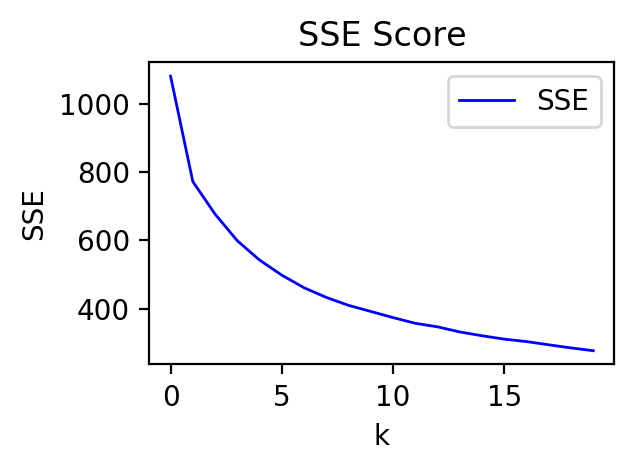

In [27]:
#kの値変更によるスコア変化を追う
max_k = 20
SSE_transition_list_wholesale = []

for k in range(1,max_k+1):
    k_means_model = ScratchKMeans(n_clusters=k)
    k_means_model.fit(data_pca)
    SSE_transition_list_wholesale.append(k_means_model.objective_function_score())

plt.figure(figsize=(3, 2), dpi=200)
plt.title('SSE Score')
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(SSE_transition_list_wholesale, color='blue',label = "SSE",linewidth=1,linestyle='solid')
plt.legend()

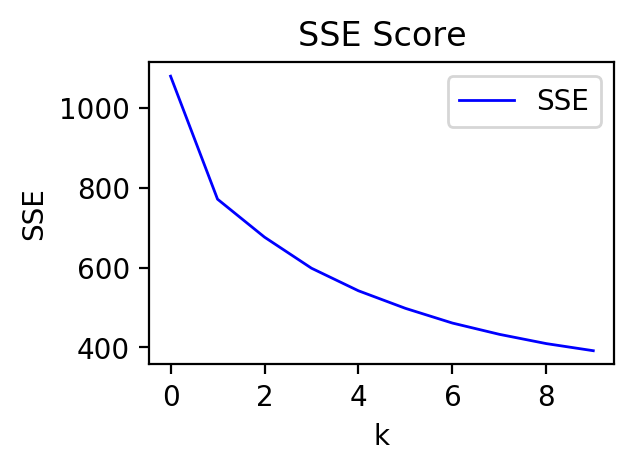

In [28]:
plt.figure(figsize=(3, 2), dpi=200)
plt.title('SSE Score')
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(SSE_transition_list_wholesale[:10], color='blue',label = "SSE",linewidth=1,linestyle='solid')
plt.legend()

### <最適なKの決定>
エルボー法によりSSEスコアの変化を追った結果、4クラスタでの分析が適当と判断した。
クラスタが増加すると、各クラスタの特性にフィットしたアプローチを行うことができ、全体の売上を伸ばすにはパフォーマンスが高くなるが、
クラスタを分けすぎると、後の思考コストやアプローチの実行コスト（手間や投資）の増加に繋がり、売上からコストを引いた利益ベースで見ると減少していく。

グラフの始点と終点を結んだ線分と並行でかつSSE曲線と接するポイントが最適なのではないか？

# 【問題5】既知のグループとの比較
###### RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。
###### クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

In [32]:
pd_data_pca = pd.DataFrame(data_pca,columns=["PCA_1","PCA_2"])
df_comparison = pd.concat([data_original.loc[:,["Channel","Region"]],pd_data_pca],axis=1,sort=True)
df_comparison.head()

,Channel,Region,PCA_1,PCA_2
0,2,3,-1.750985,-0.070515
1,2,3,-1.800365,-0.869754
2,2,3,-1.893736,-1.676621
3,1,3,1.127313,-1.457982
4,2,3,-0.796711,-2.460866


In [33]:
df_comparison['Chanel*Region'] = df_comparison['Channel'].astype(str) + '_' + df_comparison['Region'].astype(str)
df_comparison.head()

,Channel,Region,PCA_1,PCA_2,Chanel*Region
0,2,3,-1.750985,-0.070515,2_3
1,2,3,-1.800365,-0.869754,2_3
2,2,3,-1.893736,-1.676621,2_3
3,1,3,1.127313,-1.457982,1_3
4,2,3,-0.796711,-2.460866,2_3


/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


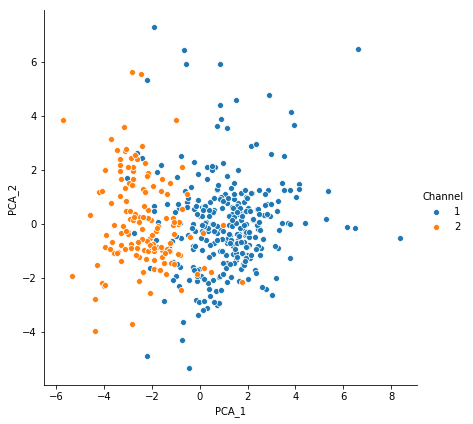

In [34]:
sns.pairplot(df_comparison, hue='Channel',size=6, x_vars=['PCA_1'], y_vars=['PCA_2'])

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


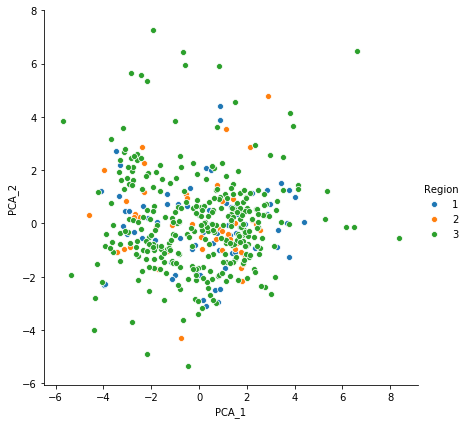

In [35]:
sns.pairplot(df_comparison, hue='Region',size=6, x_vars=['PCA_1'], y_vars=['PCA_2'])

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


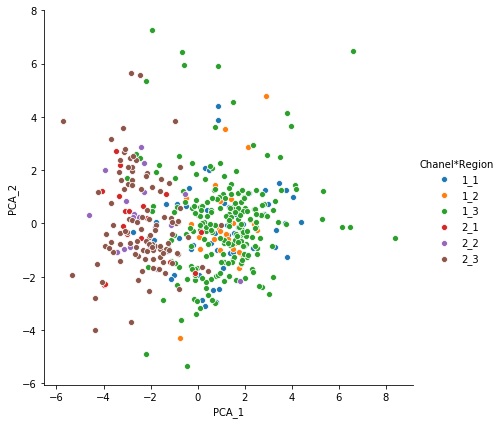

In [36]:
sns.pairplot(df_comparison, hue='Chanel*Region',size=6, x_vars=['PCA_1'], y_vars=['PCA_2'])

### k=4でクラスタリングした場合の散布図


/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


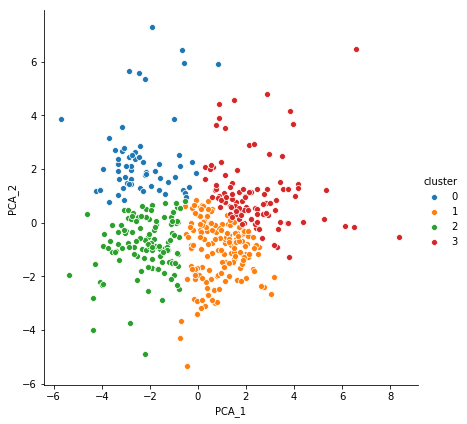

In [37]:
#色付けしたプロットとクラスタを作成
k_means_4 = ScratchKMeans(n_clusters=4)
k_means_4.fit(data_pca)
plot_data = pd.concat([pd.DataFrame(k_means_4.best_cluster_number,columns=["cluster"]),\
                       pd.DataFrame(data_pca,columns=["PCA_1","PCA_2"])],axis=1)
sns.pairplot(plot_data , hue='cluster',size=6,x_vars=['PCA_1'], y_vars=['PCA_2'])

In [38]:
#中心点の表示
k_means_4.best_center_points

array([[-2.29296615,  2.40151131],
       [ 0.92041916, -1.02999876],
       [-2.1730351 , -0.82272922],
       [ 2.34777886,  1.06365908]])

### k=2でクラスタリングした場合の散布図

/Users/tera/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


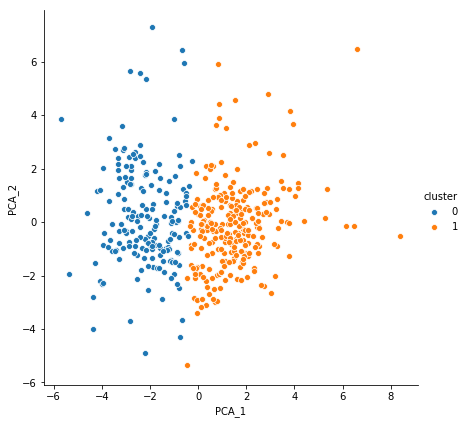

In [39]:
#色付けしたプロットとクラスタを作成
k_means_2 = ScratchKMeans(n_clusters=2)
k_means_2.fit(data_pca)
plot_data = pd.concat([pd.DataFrame(k_means_2.best_cluster_number,columns=["cluster"]),\
                       pd.DataFrame(data_pca,columns=["PCA_1","PCA_2"])],axis=1)
sns.pairplot(plot_data , hue='cluster',size=6,x_vars=['PCA_1'], y_vars=['PCA_2'])

### <考察>
クラスター０とチャネル２、クラスター１とチャネル１の分布がかなり近い。  
購買者特性に大きな違いがあるのではないか？  
対して、地域とクラスタの相関はあまり見られない。  

# 【問題6】卸売業者にとって有益な情報
###### 卸売業者にとって有益な情報を探し出し文章にまとめてください。

<font color = "red"><strong> Abstract: The data set refers to clients of a wholesale distributor.  
It includes the annual spending in monetary units (m.u.) on diverse product categories</font></strong>

Source:

Margarida G. M. S. Cardoso, margarida.cardoso '@' iscte.pt, ISCTE-IUL, Lisbon, Portugal


Data Set Information:

Provide all relevant information about your data set.


Attribute Information:

1)	FRESH: annual spending (m.u.) on fresh products (Continuous);   
2)	MILK: annual spending (m.u.) on milk products (Continuous);   
3)	GROCERY: annual spending (m.u.)on grocery products (Continuous);   
4)	FROZEN: annual spending (m.u.)on frozen products (Continuous)   
5)	DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)   
6)	DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);   
7)	CHANNEL: customers Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)   
8)	REGION: customers Region â€“ Lisnon, Oporto or Other (Nominal)   
Descriptive Statistics: 

(Minimum, Maximum, Mean, Std. Deviation) 
FRESH (	3, 112151, 12000.30, 12647.329) 
MILK	(55, 73498, 5796.27, 7380.377) 
GROCERY	(3, 92780, 7951.28, 9503.163) 
FROZEN	(25, 60869, 3071.93, 4854.673) 
DETERGENTS_PAPER (3, 40827, 2881.49, 4767.854) 
DELICATESSEN (3, 47943, 1524.87, 2820.106) 

REGION	Frequency 
Lisbon	77 
Oporto	47 
Other Region	316 
Total	440 

CHANNEL	Frequency 
Horeca	298 
Retail	142 
Total	440 

In [67]:
analysis_df_original_and_pca = pd.concat([data_original,pd.DataFrame(data_pca,columns=["PCA_1","PCA_2"])],axis=1).head()
analysis_df_log_and_pca = pd.concat([data_original.loc[:,['Channel','Region']], \
                                                       data_log,pd.DataFrame(data_pca,columns=["PCA_1","PCA_2"])],axis=1).head()

In [64]:
df_corr_original_and_pca = analysis_df_original_and_pca.corr(method='pearson')
df_corr_log_and_pca = analysis_df_log_and_pca.corr(method='pearson')

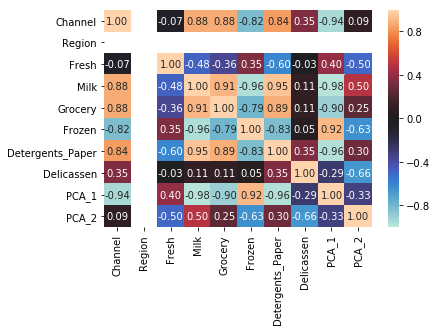

In [65]:
sns.heatmap(df_corr_original_and_pca,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=True, # True:格子の中に値を表示
            fmt='.2f',
            xticklabels=df_corr_original_and_pca.columns.values,
            yticklabels=df_corr_original_and_pca.columns.values
           )

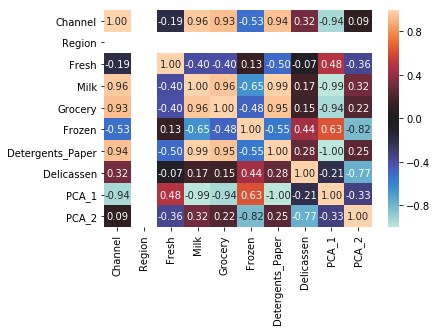

In [66]:
sns.heatmap(df_corr_log_and_pca,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=True, # True:格子の中に値を表示
            fmt='.2f',
            xticklabels=df_corr_log_and_pca.columns.values,
            yticklabels=df_corr_log_and_pca.columns.values
           )

### <考察>
PCA_1はMilk,Grocery,Dtergent_Paperが重要な成分になっている。  
PCA_2はFrozen,Delicassenが重要な成分になっている。
今回注目したチャネルに関して、境界として機能していたのはPCA_1である。

そして、PCA_1が大きなグループはチャネル１(ホテル、レストラン、カフェなどBtoB)、PCA_1が小さなグループはチャネル２（小売などBtoC）であった。  
  
チャネル１(ホテル、レストラン、カフェなどBtoB)では大型の取引が行われていることが推定される。  
Milk,Grocery,Dtergent_Paperが販売構成比として大きく、これらの商材の利益向上を狙うのが第一に検討すべき筋である。  
  
チャネル２（小売などBtoC）では、一般消費者の購買が中心となる。  
顧客ごとの客単価にチャネル１ほど大きな分散は見られないという仮説があり、  
商材を絞り切るのではなく、品揃えを重視した集客をすることで顧客を集めることが必要かもしれない。